### Libraries

In [8]:
import os

import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn

import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge,ElasticNet,LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,accuracy_score,mean_squared_error, r2_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from plotly.subplots import make_subplots

### Upload Dataset

In [9]:
# Get the current working directory
directorio_actual = os.getcwd()

# Specify the relative path from the current directory
ruta_csv_relativa = os.path.join('..', 'data', '01_raw','spotify.csv')

# Load the CSV file
spotify = pd.read_csv(ruta_csv_relativa)

# Linear Regression (Diego)

## ¿How does mood influence the intensity of songs, and can we use this relationship to create playlists with a specific flow of energy?

### If we find a strong relationship, with a high R², we could say that happier songs (high valence) tend to have greater energy. This would allow you to create playlists that maintain a flow of energy or mood transitions in a more structured way. For example, if we want a playlist that goes from relaxed to intense, we could organize the songs by "valence" and anticipate that their energy will increase naturally.

Coefficient of Determination (R²): 0.05868640054022267
Mean Squared Error (MSE): 0.0534498448527597


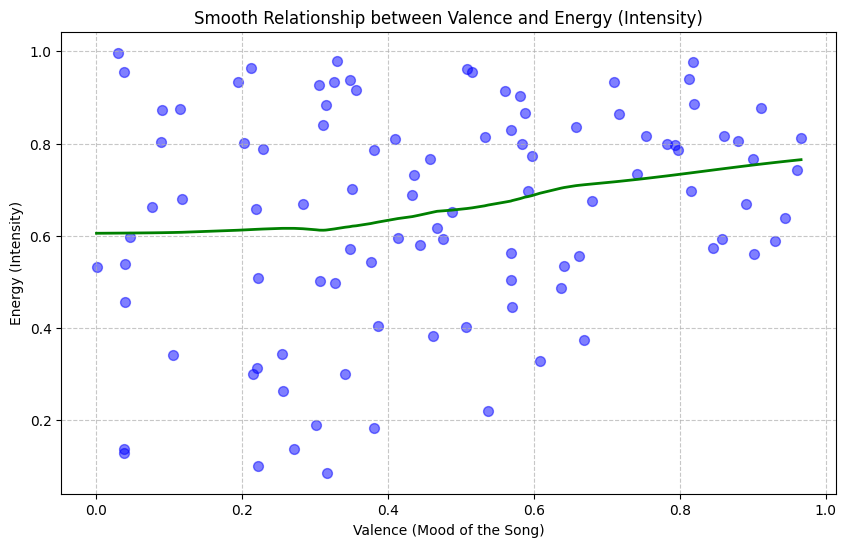

In [25]:
spotify_sample_100 = spotify.sample(n=100, random_state=42)

# Define variables
X_sample_100 = spotify_sample_100[['valence']]  # Reshape to 2D for the model
y_sample_100 = spotify_sample_100['energy']

# Fit linear regression model
model = LinearRegression()
model.fit(X_sample_100, y_sample_100)

# Predictions
y_pred = model.predict(X_sample_100)

# Calculate R² and MSE
r2 = r2_score(y_sample_100, y_pred)
mse = mean_squared_error(y_sample_100, y_pred)

print(f"Coefficient of Determination (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X_sample_100['valence'], y=y_sample_100, scatter_kws={'color': 'blue', 'alpha':0.5, 's':50},
            line_kws={'color': 'green', 'lw': 2}, lowess=True)
plt.title("Smooth Relationship between Valence and Energy (Intensity)")
plt.xlabel("Valence (Mood of the Song)")
plt.ylabel("Energy (Intensity)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Logistic regression model to predict whether a song is "popular" (Diego)

In [11]:
# Define a dependent variable (example: popularity > 50)
spotify['popular'] = (spotify['popularity'] > 50).astype(int)

# Select the independent variables (numeric data only)
X = spotify[['danceability', 'energy', 'key', 'loudness', 
              'mode', 'speechiness', 'acousticness', 'instrumentalness', 
              'liveness', 'valence', 'tempo', 'time_signature']]

#Define the dependent variable
y = spotify['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Create and train the model
model = LogisticRegression(max_iter=2000) # Increase to 2000 iterations
model.fit(X_train_scaled, y_train)

#Make predictions
y_pred = model.predict(X_test_scaled)

#Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[17332     1]
 [ 5467     0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     17333
           1       0.00      0.00      0.00      5467

    accuracy                           0.76     22800
   macro avg       0.38      0.50      0.43     22800
weighted avg       0.58      0.76      0.66     22800



### Linear Regression (Diego)

In [12]:
# Define target variable: 'popular' (popularity > 50)
spotify['popular'] = (spotify['popularity'] > 50).astype(int)

# Select features (independent variables)
X = spotify[['danceability', 'energy', 'key', 'loudness', 'mode', 
             'speechiness', 'acousticness', 'instrumentalness', 
             'liveness', 'valence', 'tempo', 'time_signature']]
y = spotify['popular']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[17040   293]
 [ 2904  2563]]
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     17333
           1       0.90      0.47      0.62      5467

    accuracy                           0.86     22800
   macro avg       0.88      0.73      0.77     22800
weighted avg       0.86      0.86      0.84     22800



# Model of Regression (Diego)

### We use this model to predict whether a song is popular or not

In [13]:
spotify.dropna(inplace=True)

# Define target variable: 'popular' (popularidad > 50)
spotify['popular'] = (spotify['popularity'] > 50).astype(int)

# Select independent variables (numeric columns)
X = spotify[['danceability', 'energy', 'key', 'loudness', 'mode', 
             'speechiness', 'acousticness', 'instrumentalness', 
             'liveness', 'valence', 'tempo', 'time_signature']]
y = spotify['popular']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test_scaled)

# Evaluate the model
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[14615  2698]
 [ 2226  3261]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86     17313
           1       0.55      0.59      0.57      5487

    accuracy                           0.78     22800
   macro avg       0.71      0.72      0.71     22800
weighted avg       0.79      0.78      0.79     22800



# Model Of Classification (Diego)

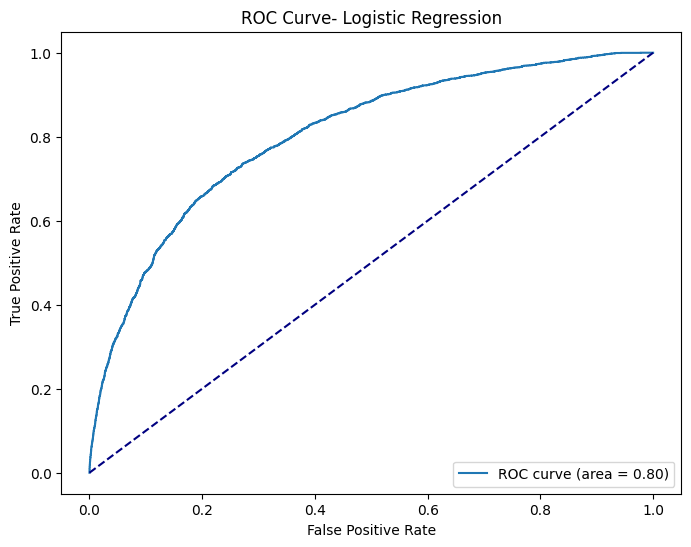

In [14]:
#Preprocessing: Selection of relevant numerical variables
features = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

#Target and predictor variables
X = spotify[features]
y = spotify['explicit'].astype(int) # We convert the 'explicit' variable into binary (0 or 1)

#Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#Logistic regression model training
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

#Predictions
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

#ROC Curve Generation
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

#Graph Generation
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### Clasificación

# Model Of Classification KNN (Diego)

### The goal here is to predict whether a song is "explicit" or not.

In [15]:
# We use features from the dataset for classification
X_class = spotify[['danceability', 'energy', 'acousticness', 'valence']]
y_class = spotify['explicit'] # Rating based on whether the song is explicit or not

# Split the data into training and testing
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Create the KNN classification model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_class, y_train_class)

# Making predictions
y_pred_knn = knn.predict(X_test_class)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_knn)
print(conf_matrix)

# Calculate the ranking report
report = classification_report(y_test_class, y_pred_knn)
print(report)

# Calculate the accuracy
accuracy_knn = accuracy_score(y_test_class, y_pred_knn)
print("Accuracy:", accuracy_knn)

[[20442   462]
 [ 1440   456]]
              precision    recall  f1-score   support

       False       0.93      0.98      0.96     20904
        True       0.50      0.24      0.32      1896

    accuracy                           0.92     22800
   macro avg       0.72      0.61      0.64     22800
weighted avg       0.90      0.92      0.90     22800

Accuracy: 0.916578947368421


# Model Of Classification Random Forest (Diego)

### What features like "energy", "acousticness", "valence", and "danceability" can predict whether a song has explicit content or not on Spotify?

In [16]:
# Usamos características del dataset para la clasificación
X_class_rf = spotify[['danceability', 'energy', 'acousticness', 'valence']]
y_class_rf = spotify['explicit']  # Clasificación basada en si la canción es explícita o no

# Dividir los datos en entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_class_rf, y_class_rf, test_size=0.2, random_state=42)

# Crear el modelo de clasificación Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf.fit(X_train_rf, y_train_rf)

# Hacer predicciones
y_pred_rf = rf.predict(X_test_rf)

# Calcular e imprimir la matriz de confusión y reporte de clasificación
print(confusion_matrix(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))


[[20830    74]
 [ 1149   747]]
              precision    recall  f1-score   support

       False       0.95      1.00      0.97     20904
        True       0.91      0.39      0.55      1896

    accuracy                           0.95     22800
   macro avg       0.93      0.70      0.76     22800
weighted avg       0.94      0.95      0.94     22800

Accuracy: 0.946359649122807


### Regresión Lineal Ordinaria "OLS" (Carlos)

In [17]:
# Ruta donde se guardaran los modelos
ruta_modelos = os.path.join('..', 'data', '06_models')

X = spotify[['danceability', 'energy', 'valence']]
y = spotify['popularity']

X = sm.add_constant(X)

modelo_lineal = sm.OLS(y, X).fit()

print(modelo_lineal.summary())

# Guardar el modelo
joblib.dump(linear_model, os.path.join(ruta_modelos, 'modelo_lineal_carlos_1.pkl'))

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     216.1
Date:                Sat, 26 Oct 2024   Prob (F-statistic):          8.95e-140
Time:                        23:40:26   Log-Likelihood:            -5.1538e+05
No. Observations:              113999   AIC:                         1.031e+06
Df Residuals:                  113995   BIC:                         1.031e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           30.5770      0.265    115.191   

['..\\data\\06_models\\modelo_lineal_carlos_1.pkl']

Resumen:

1) R-squared (0.006): El R² es muy bajo, lo que significa que solo el 0.6% de la variación en la popularidad de las canciones puede ser explicada por las variables danceability, energy, y valence. Este es un valor bajo, lo que sugiere que existen otros factores importantes no considerados en el modelo que explican la popularidad.

2) danceability (coef = 9.10, p < 0.05): El coeficiente es positivo y significativo, lo que indica que a mayor danceability, mayor es la popularidad. El impacto es relativamente grande.

3) energy (coef = 1.03, p < 0.05): El coeficiente es positivo y significativo, pero el efecto es menor en comparación con danceability. Esto significa que un aumento en energy también tiende a aumentar la popularidad, pero su influencia es más débil.

4) valence (coef = -6.65, p < 0.05): El coeficiente es negativo y significativo. Esto significa que a mayor valence (felicidad o positividad en la canción), menor es la popularidad. Este resultado es interesante porque podría significar que las canciones con un ambiente más alegre o positivo tienden a ser menos populares en este dataset.

Las canciones con más 'danceability' y 'energy' tienden a ser más populares, pero la variable 'valance' tiene un impacto negativo en la popularidad al momento de predecir el campo.

In [18]:
# Seleccionar las variables numéricas que influirán en la recomendación de canciones
X = spotify[['danceability', 'energy', 'valence']]  # Variables independientes
y = spotify['explicit'].astype(int)  # Variable dependiente (convertimos bool a int)

# Añadir una constante para el término de intercepción en el modelo
X = sm.add_constant(X)

# Ajustar el modelo de regresión logística
modelo_logistico = sm.Logit(y, X).fit()

# Mostrar el resumen del modelo
print(modelo_logistico.summary())

Optimization terminated successfully.
         Current function value: 0.275578
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               explicit   No. Observations:               113999
Model:                          Logit   Df Residuals:                   113995
Method:                           MLE   Df Model:                            3
Date:                Sat, 26 Oct 2024   Pseudo R-squ.:                 0.05625
Time:                        23:40:27   Log-Likelihood:                -31416.
converged:                       True   LL-Null:                       -33288.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.2251      0.061    -85.383      0.000      -5.345      -5.105
danceability     3.6914

Resumen:

1) Pseudo R-squared (0.05625): Aunque no es directamente comparable con el R² de la regresión lineal, este valor es relativamente bajo, lo que indica que las variables seleccionadas no explican gran parte de si una canción es explícita o no. Sin embargo, el modelo sigue siendo significativo.

2) danceability (coef = 3.69, p < 0.05): Un coeficiente positivo y alto indica que las canciones con mayor danceability tienen una mayor probabilidad de ser explícitas.

3) energy (coef = 1.89, p < 0.05): Un coeficiente positivo también significativo indica que las canciones con más energy tienen una mayor probabilidad de ser explícitas, aunque su efecto es menor que el de danceability.

4) valence (coef = -1.37, p < 0.05): Un coeficiente negativo indica que las canciones con mayor valence (más felices o positivas) son menos propensas a ser explícitas.

Las canciones con indices mayores en 'danceability' y 'energy' tiene más probabilidad de ser canciones con letras explicitas, mientras que las canciones con un mayor 'valance' lo contrario.

### Regresión Lineal con Ridge (Carlos)

In [19]:
X = spotify[['danceability', 'energy', 'valence']]
y = spotify['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

y_pred = ridge_model.predict(X_test_scaled)

print(ridge_model.coef_)
print("Score:", ridge_model.score(X_test_scaled, y_test))

[ 1.57510463  0.23691123 -1.74247892]
Score: 0.00520557130278998


### Regresión Logística Multinomial

In [20]:
le = LabelEncoder()
spotify['track_genre_encoded'] = le.fit_transform(spotify['track_genre'])

X = spotify[['danceability', 'energy', 'valence']]
y = spotify['track_genre_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
logistic_multinomial.fit(X_train, y_train)

y_pred = logistic_multinomial.predict(X_test)

print("Score:", logistic_multinomial.score(X_test, y_test))

C:\Users\diego\OneDrive\Imágenes\Escritorio\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Score: 0.06824561403508772


### Regresión Lineal con ElasticNet (Carlos)

In [21]:
X = spotify[['danceability', 'energy', 'valence', 'popularity', 'loudness', 'acousticness', 
             'instrumentalness', 'speechiness', 'tempo']]

y = spotify['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # l1_ratio entre 0 y 1 controla la mezcla de L1 y L2
elastic_net_model.fit(X_train, y_train)

y_pred = elastic_net_model.predict(X_test)

score = elastic_net_model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print("Coeficientes:", elastic_net_model.coef_)
print("Score (R²):", score)
print("MSE:", mse)

Coeficientes: [ 0.         -0.         -0.          0.99799335  0.         -0.
 -0.         -0.          0.        ]
Score (R²): 0.9999959726342538
MSE: 0.0019979337526169288


Coeficientes:

La mayoría de los coeficientes de las variables seleccionadas son 0 o valores muy cercanos a 0, excepto el coeficiente de popularity, que es 0.9979. Esto indica que la variable "popularity" es la que tiene mayor peso o influencia sobre el modelo. Las demás variables seleccionadas no contribuyen significativamente a predecir el resultado.

Score (R²):

El valor R² = 0.9999959 es extremadamente alto, lo que significa que el modelo explica casi el 100% de la variabilidad en los datos. Sin embargo, un R² tan elevado puede ser una señal de sobreajuste.

MSE (Error Cuadrático Medio):

MSE = 0.00199 es un valor muy bajo, lo cual sugiere que el modelo comete muy pocos errores en la predicción de los valores de la variable dependiente (popularidad). Al igual que con el R², este bajo error podría ser un indicador de que el modelo se ha ajustado demasiado bien a los datos de entrenamiento.

Conclusión: El modelo parece estar sobreajustado, lo que significa que se ajusta demasiado bien a los datos de entrenamiento, pero podría no generalizar bien a nuevos datos. El hecho de que la mayoría de los coeficientes sean 0 indica que la mayoría de las variables no son relevantes para este modelo.

### Regresión Logística OvR (One-vs-Rest)

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión logística One-vs-Rest con más iteraciones
logistic_ovr_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=500))
logistic_ovr_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = logistic_ovr_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)

print("Score (Exactitud):", accuracy)

Score (Exactitud): 0.1856140350877193


La exactitud del modelo es 0.1765, lo que indica que el modelo predice correctamente el 17.65% de las veces. Este es un valor bajo para un modelo de clasificación, lo que sugiere que no está funcionando bien para predecir la clase correcta (género de la canción).

Conclusión: El modelo de regresión logística OvR no está prediciendo de manera efectiva el género de la canción. Esto puede deberse a la complejidad del problema, la falta de información relevante en los datos o que se necesiten más variables o un enfoque de modelado diferente para mejorar la exactitud.


Métricas de comparación de los modelos:

Modelo de Regresión Lineal 1 (Compañero): MSE = 485.48, R2 = 0.02
Modelo de Regresión Lineal 2 (Tu modelo): MSE = 492.94, R2 = 0.01


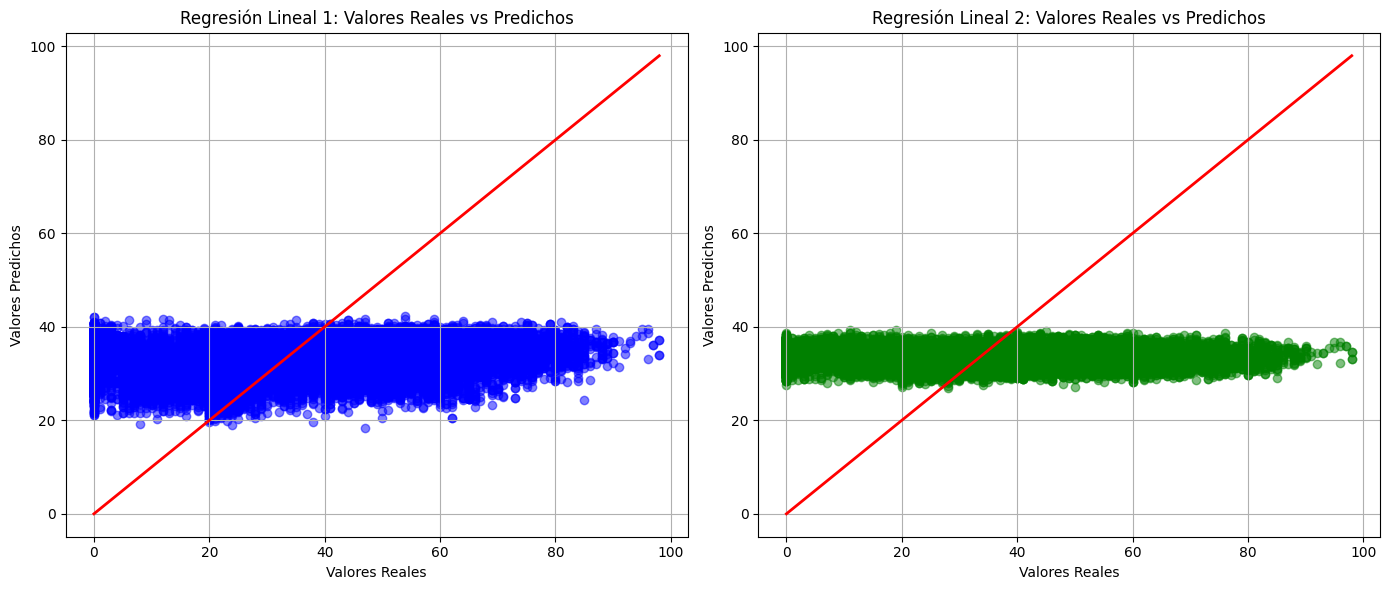

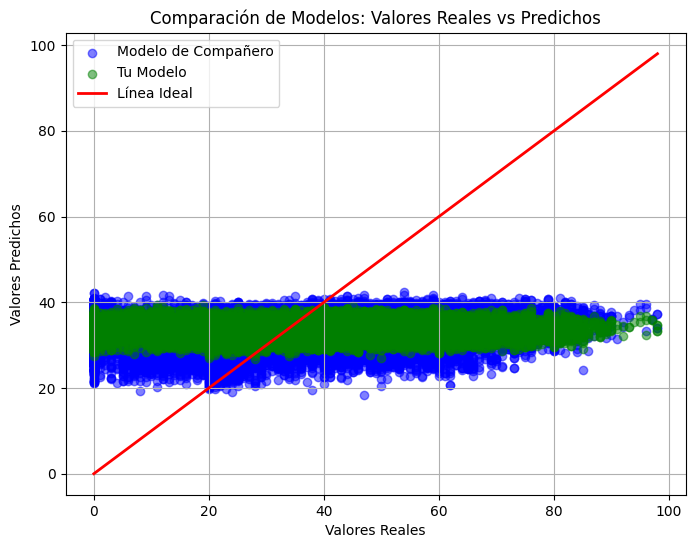

In [23]:
# Ruta de la carpeta donde están guardados los modelos
ruta_modelos = os.path.join('..', 'data', '06_models')

# ---- REGRESIÓN LINEAL 1 (Modelo de tu compañero) ----
# Seleccionar características para el modelo de regresión
X = spotify[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
              'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
y = spotify['popularity']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predecir usando el conjunto de prueba
y_pred_linear = linear_model.predict(X_test)

# Calcular métricas para la Regresión Lineal 1
mse1 = mean_squared_error(y_test, y_pred_linear)
r2_1 = r2_score(y_test, y_pred_linear)

# Guardar el modelo
joblib.dump(linear_model, os.path.join(ruta_modelos, 'modelo_lineal_diego_1.pkl'))

# ---- REGRESIÓN LINEAL 2 (Tu modelo) ----
# Seleccionar características para tu modelo de regresión
X_carlos = spotify[['danceability', 'energy', 'valence']]
y_carlos = spotify['popularity']

X_carlos = sm.add_constant(X_carlos)

modelo_lineal_carlos = sm.OLS(y_carlos, X_carlos).fit()

# Realizar predicciones con el conjunto de prueba (usando el mismo conjunto que el modelo de tu compañero)
y_carlos_pred = modelo_lineal_carlos.predict(sm.add_constant(X_test[['danceability', 'energy', 'valence']]))

# Calcular métricas para la Regresión Lineal 2
mse2 = mean_squared_error(y_test, y_carlos_pred)
r2_2 = r2_score(y_test, y_carlos_pred)

# Guardar el modelo
joblib.dump(modelo_lineal_carlos, os.path.join(ruta_modelos, 'modelo_lineal_carlos_1.pkl'))

# ---- COMPARACIÓN ----
print(f"\nMétricas de comparación de los modelos:\n")
print(f"Modelo de Regresión Lineal 1 (Compañero): MSE = {mse1:.2f}, R2 = {r2_1:.2f}")
print(f"Modelo de Regresión Lineal 2 (Tu modelo): MSE = {mse2:.2f}, R2 = {r2_2:.2f}")

# ---- Gráficos de Dispersión ----

# Gráficos de dispersión para ambos modelos de Regresión Lineal
plt.figure(figsize=(14, 6))

# Regresión Lineal 1
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Regresión Lineal 1: Valores Reales vs Predichos")
plt.grid(True)

# Regresión Lineal 2
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_carlos_pred, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Regresión Lineal 2: Valores Reales vs Predichos")
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- Gráfico Superpuesto ----
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, color='blue', alpha=0.5, label='Modelo de Compañero')
plt.scatter(y_test, y_carlos_pred, color='green', alpha=0.5, label='Tu Modelo')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Línea Ideal')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación de Modelos: Valores Reales vs Predichos")
plt.legend()
plt.grid(True)
plt.show()